# Text Analysis with SQL Server Machine Learning Services, revoscalepy and microsoftml

### The goal: visualize and analyze text data without it leaving the SQL Server machine! 

When a customer sends a support ticket, it is important to route it to the right team. In this notebook, we train a model to predict which team a support ticket belongs to based on the subject and text of the ticket. 

With SQL Server ML Services, we can visualize the data and train the model on the SQL Server machine, without the data ever having to leave!

## Setup our SQL Server compute context

This "compute context" will allow us to easily execute arbitrary Python functions on our SQL Server machine.

In [14]:
%load_ext autoreload
%autoreload 2
from revoscalepy import RxInSqlServer, rx_exec
import os
import sqlpyutils

server = "52.151.58.35"
db = "TextClassification_Py"
user = os.environ["MY_SQL_USER"]
pwd = os.environ["MY_SQL_PWD"]
connection_string = "Driver=SQL Server;Server={};Database={};Uid={};Pwd={};".format(server, db, user, pwd)

sql_compute_context = RxInSqlServer(connection_string=connection_string)
connection = sqlpyutils.ConnectionInfo(server=server, database=db, uid=user, pwd=pwd)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Visualize the data

### Lets do some data visualization with a word cloud of the Subject column.

We use the `rx_exec` function below to execute `generate_wordcloud` on our SQL Server machine. This processes the data "In-DB", generates a wordcloud, and returns the wordcloud object the client. Of course, the data never leaves the machine :)

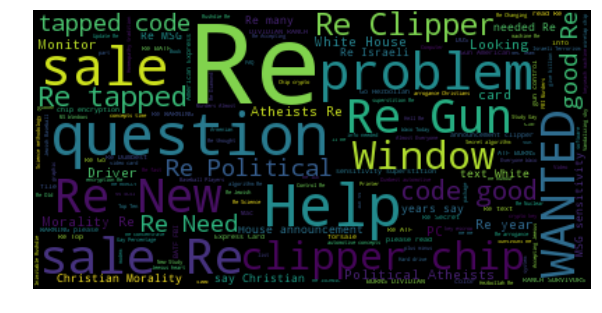

In [16]:
import matplotlib.pyplot as plt

def generate_wordcloud():
    from wordcloud import WordCloud
    text = " ".join(InputDataSet["Subject"])
    return WordCloud(max_font_size=80).generate(text)

wc = sqlpyutils.execute_in_sql(connection, generate_wordcloud, input_data_query="select * from News_Train")

plt.figure(figsize=(10,10))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

### More visualization with a histogram of string lengths for the Subject column

Once again, we use `rx_exec` to execute `generate_histogram` on the SQL Server machine. The data never leaves, just the bytes of the histogram image.

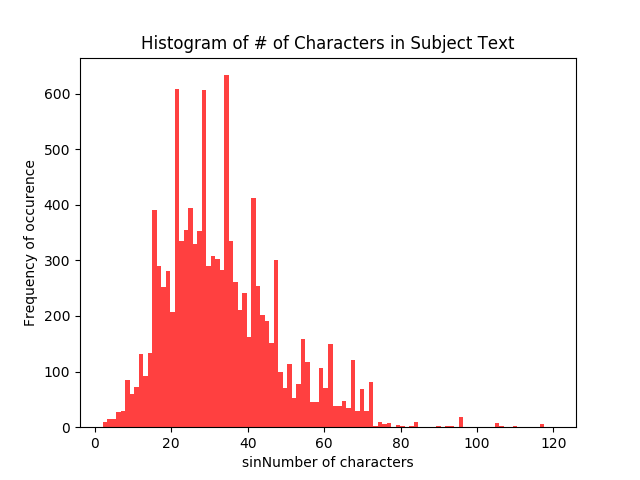

In [11]:
from IPython import display

def generate_histogram():
    import matplotlib.pyplot as plt
    import io
    
    plt.hist(InputDataSet["Subject"].str.len(), 100, facecolor='red', alpha=0.75)
    plt.title('Histogram of # of Characters in Subject Text')
    plt.xlabel('sinNumber of characters')
    plt.ylabel('Frequency of occurence')
    
    buf = io.BytesIO()
    plt.savefig(buf, format="png")
    buf.seek(0)
    
    return buf.getvalue()

histogram = sqlpyutils.execute_in_sql(connection, generate_histogram, input_data_query="select * from News_Train")
display.Image(data=histogram)

## Define the featurization for the training set

We can train a more accurate model if we extract the most important information from the raw string data. 

In this step, we use the featurize_text function from the microsoftml module to define a transformation. We do not actually perform the transformation.

The transformation we define removes nonessential information from the input data, such as numbers and diacritics. It also hashes different words in the data for processing. 

This process is often referred to as "featurizing" the data. We are trying to extract the "features" of the data we want to train our model based on.

In [12]:
from microsoftml import featurize_text
from microsoftml.entrypoints._stopwordsremover_predefined import predefined
from microsoftml import featurize_text, n_gram_hash

# Define the transformation to be used to generate features. 
# It will be applied on the fly during training and testing.
# Here, for each the text and subject of the data, we: 
# - Remove stopwords, diacritics, punctuation and numbers.
# - Change capital letters to lower case. 
# - Hash the different words and characters. 
# The parameters or options can be further optimized by parameter sweeping.
# Other languages can be used.
text_transform_list = [featurize_text(cols = dict(SubjectPreprocessed = "Subject", TextPreprocessed = "Text"), 
                                     language = "English",
                                     stopwords_remover = predefined(),
                                     case = "Lower",
                                     keep_diacritics  = False,                                                   
                                     keep_punctuations = False,
                                     keep_numbers = False,
                                     word_feature_extractor = n_gram_hash(hash_bits = 17, ngram_length = 2, seed = 4),
                                     char_feature_extractor = n_gram_hash(hash_bits = 17, ngram_length = 3, seed = 4),
                                     vector_normalizer = "L2")]

## Train the model

Now that we have the feature transformation setup, we can actually train the model. 

In this code, we first get a list of the distinct labels in the training set. We feed the information to our model so it knows how many classes of data it is dealing with.

We then setup our training formula ("Label ~ SubjectPreprocessed + TextPreprocessed"). This formula states, train a model that predicts Label based on the SubjectPreprocessed and TextPreprocessed columns. (These columns are the outputs of our transformation defined above). 

## In-Database Model Training

You may notice the compute_context parameter we pass into the call to rx_logistic_regression. The argument we pass indicates that the model should be trained "In-DB". Thus, the computation is "shipped" to the SQL Server machine. All of the model training happens on the SQL Server, and the data never has to leave the machine!

In [ ]:
from revoscalepy import rx_set_compute_context, RxInSqlServer, RxLocalSeq, RxOdbcData, rx_write_object, RxSqlServerData, rx_import
from microsoftml import rx_logistic_regression, rx_predict

# Write the distinct label values into an information dict for logistic model
sql_distinct_labels = RxSqlServerData(sql_query = "SELECT DISTINCT Label FROM News_Train",
                              connection_string = connection_string)
levels_list  = list(rx_import(sql_distinct_labels)['Label'])
factor_info = {'Label':{'type' : 'factor', 'levels' : [str(s) for s in levels_list]}}

sql_news_train = RxSqlServerData(connection_string=connection_string, sql_query = "select * from News_Train", 
                                 column_info=factor_info)

# Train the multiclass logistic regression model on the SQL Server.
training_formula = "Label ~ SubjectPreprocessed + TextPreprocessed"
logistic_model = rx_logistic_regression(formula = training_formula,
                                        data = sql_news_train,
                                        method = "multiClass",
                                        l2_weight = 1, 
                                        l1_weight = 1,
                                        ml_transforms = text_transform_list,
                                        train_threads = 4,
                                        compute_context = sql_compute_context)

# Save serialized model to SQL Server
models_odbc = RxOdbcData(connection_string, table = "Model")
rx_write_object(models_odbc, key = "LR", value = logistic_model, serialize = True, overwrite = True)

## Score the model and show predictions

Now that we have a model trained, we want to see how it performs on some test data.

In this code, we use rx_predict to predict with our model on test data stored in the News_Test table. We use the output_data argument to rx_predict to store the prediction in the Predictions_Intermediate table.

Note the compute_context argument to rx_predict. <b>The prediction all happens on the SQL Server machine!</b>

We then use a SQL join query to show a sample of what our model predicts versus the actual Label values. Note: below we do allow the Label and PredictedLabel data to leave the machine, but none of the actual Subject/Text information.

In [ ]:
from revoscalepy import rx_data_step

# Logistic Regression Scoring

# Point to the testing set. 
sql_news_test = RxSqlServerData(table = "News_Test",
                                connection_string = connection_string,
                                column_info = factor_info)

# Make Predictions while featurizing the text variables separately on the fly.
# This will automatically use the same text transformation as in the training, encoded in logistic_model.
sql_predictions_intermediate = RxSqlServerData(table = "Predictions_Intermediate", connection_string = connection_string)

rx_predict(model = logistic_model,
           data = sql_news_test,
           output_data = sql_predictions_intermediate,
           extra_vars_to_write = ["Label", "Id"],
           overwrite = True, 
           compute_context=RxInSqlServer(connection_string=connection_string))

sql_predictions_join = RxSqlServerData(sql_query = "SELECT LabelNames, Predictions_Intermediate.* \
                                              FROM Predictions_Intermediate INNER JOIN Label_Names \
                                              ON Predictions_Intermediate.PredictedLabel = Label_Names.Label", 
                                connection_string = connection_string)

sql_predictions = RxSqlServerData(table = "Predictions", connection_string = connection_string, strings_as_factors = True)
rx_data_step(input_data = sql_predictions_join, output_file = sql_predictions, 
             overwrite = True, compute_context=sql_compute_context)

df_predictions = rx_import(sql_predictions)
df_predictions.head(10)

## Model accuracy on test data

Below we show confusion matrix calculated from our predictions on the test data, versus the actual values.

In [ ]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report

# Evaluate the model.
conf_matrix = confusion_matrix(y_true = df_predictions["Label"], y_pred = df_predictions["PredictedLabel"])

# Compute Evaluation Metrics. 
## Micro Average accuracy: 
micro = sum(conf_matrix[i][i] for i in range(conf_matrix.shape[0]))/df_predictions.shape[0]
print("Micro Average Accuracy is {}".format(micro))

## Macro Average accuracy:
macro = sum(conf_matrix[i][i]/(sum(conf_matrix[i][j] for j in range(conf_matrix.shape[0]))) for i in range(conf_matrix.shape[0]))/conf_matrix.shape[0]
print("Macro Average Accuracy is {}".format(macro))

## Per-class precision, recall and F1-score. 
results = classification_report(y_true = df_predictions["Label"], y_pred = df_predictions["PredictedLabel"])
print(results)